# Bias accuracy requirements

The required accuracy of a theoretical halo bias model is dictated by the level of statistical accuracy achieved in a given analysis. The halo bias will be used primarily in two ways: cluster weak lensing and cluster clustering. 

## Weak lensing term

For weak lensing, the dominant source of uncertainty in DES Y1 (and likely in the future) is shape noise. Shape noise scales approximately inversely with the volume of the survey and the source density. Of course, everything is mass dependent. Writing it all out we see
$$
\sigma_{\ln b}^2 = \frac{1}{b^2}\left(\frac{db}{dM}\right)^2\sigma_M^2 = \frac{1}{b^2}\left(\frac{db}{dM}\right)^2\left(\frac{dM}{d\Delta\Sigma}\right)^2\sigma_{\Delta\Sigma}^2
$$
Melchior et al. (2017) found $M\propto\Delta\Sigma^{4/3}$ so that we can write the derivative of the mass with respect to lensing as
$$
\frac{dM}{d\Delta\Sigma} \propto \frac{4}{3}M^{1/4}\,.
$$
From here, we can now write the uncertainty on the bias as
$$
\sigma_{\ln b}^2 = \frac{1}{b^2}\left(\frac{db}{dM}\right)^2 \frac{16}{9} M^{1/2}\sigma_{\Delta\Sigma}^2
$$
The statistical uncertainty on $\Delta\Sigma$ looks like
$$
\sigma_{\Delta\Sigma}^2 = \frac{A_{\Delta\Sigma}}{N_c n_0}\exp\left(\frac{1}{2}\frac{z^2}{z_*^2}\right)
$$
where $A_{\Delta\Sigma}$ is some constant that must be estimated using data. The number of clusters $N_c$ is given by 
$$
N_c = V\int_{M-\Delta M}^{M+\Delta M}dM \frac{dn}{dM}\,,
$$
where $\Delta M = \frac{M}{5}\ln 10$, or a 20% change in $\log_{10}M$. The exponential term models the source density behind a bin of clusters in a redshift slice with width $\Delta z=0.15$. Modeling $\sigma_{\Delta\Sigma}^2$ against the DES Y1 cluster lensing measurements, we found $A_{\Delta\Sigma}$ to be $4.4\times10^{21} [h^{-1}{\rm M}_\odot]^{1.5}\ {\rm arcmin}^{-2}$ and $z_*=0.33$. Plugging this all in together we find the required accuracy on the halo bias for weak lensing analyses is
$$
\sigma_{\ln b}^2 = \frac{1}{b^2}\frac{16}{9}M^{1/2}\left(\frac{db}{dM}\right)^2 \frac{A_{\Delta\Sigma}}{N_c n_0}\exp\left(\frac{1}{2}\frac{z^2}{z_*^2}\right)\,.
$$

## Cluster clustering term

For cluster clustering, we can relate the required accuracy of the bias in the following way. Let $\sigma_{\ln b}^2$ be the square of the uncertainty on the bias. Propagating uncertainty we can then write
$$
\sigma_{\ln b}^2 = \frac{\sigma_b^2}{b^2}\,.
$$
From here we can write the uncertainty on the bias as a function of uncertainty on cluster clustering $\sigma_{\xi_{\rm hh}}^2$ as
$$
\sigma_b^2 = \left(\frac{db}{d\xi_{\rm hh}}\right)^2\sigma_{\xi_{\rm hh}}^2\,.
$$
The derivative is given by
$$
\frac{d\xi_{\rm hh}}{db} = 2\frac{\xi_{\rm hh}}{b}\,,
$$
meaning the dependence on the bias from the derivative will cancel the factor in the first equation. Using this, we can now write the uncertainty on the bias as
$$
\sigma_b^2 = \frac{b^2}{4}\frac{\sigma_{\xi_{\rm hh}}^2}{\xi_{\rm hh}^2} = \frac{b^2}{4}\sigma_{\ln\xi_{\rm hh}}^2\,,
$$
Where the last term is the fractional uncertainty on the halo clustering. This uncertainty is shot noise dominated. Shot noise scales inversely with the number density squared, according to
$$
\sigma_{\ln\xi_{\rm hh}}^2 = \frac{A_{\xi_{\rm hh}}}{N_c^2}\,,
$$
where $A_{\xi_{\rm hh}}$ is a constant that must be estimated from data. The only data we have available is from Baxter et al. (2017). Inspecting the figures in their appendix, we estimate a precision of 50% at a halo mass of $M\approx 10^{14}\ [h^{-1}{\rm M}_\odot]$. Using the fact that they observed clusters in a redshift slice of width $\Delta z=0.08$ with a survey area of 10,000 square degrees, we compute the constant to be $A_{\xi_{\rm hh}} = 1.75\times10^{7}$. Putting it all together, we find that the fractional uncertainty on the bias is
$$
\sigma_{\ln b}^2 = \frac{A_{\xi_{\rm hh}}}{4N_c^2}
$$




In [1]:
import numpy as np
from classy import Class #for k and P(k)
import cluster_toolkit as ct
import bias_emulator
import hmf_emulator
import matplotlib.pyplot as plt
from scipy.integrate import quad
%matplotlib inline

In [2]:
plt.rc("text", usetex=True)
plt.rc("font", size=18, family="serif")

In [3]:
#Some axis labels
y_axis_label = r"Statistical Precision $[\%]$"
scale = 100 #100 puts things in %. 1 puts things in fractions

In [4]:
#Define areas, source densities, and zstars for different surveys
names = ["DES Y1", "DES Y5", "LSST Y1"]
source_densities = [6.3, 8.4, 10.]
Amplitude = 0.07*1e22*source_densities[0] #parameter fitted to DES Y1 data; degenerate with source density
print("Lensing amplitude: ",Amplitude)
zstars = [0.33, 0.6, 0.85]
str_per_sqdeg = (np.pi/180)**2
areas = np.array([1514., 5000., 18000.])*str_per_sqdeg #survey areas
frac_over = 1.0 #fraction over statistical uncertainty allowed for the theory

('Lensing amplitude: ', 4.4100000000000005e+21)


In [5]:
Omega_b = 0.05
Omega_m = 0.3
Omega_cdm = Omega_m - Omega_b
h = 0.7
params = {
        'output': 'mPk',
        "h":h,
        "A_s":1.9735e-9, #Yields sigma8 = 0.8
        "n_s":0.96,
        "Omega_b":Omega_b,
        "Omega_cdm":Omega_cdm,
        'P_k_max_1/Mpc':100.,
        'z_max_pk':1.0}
cosmo = Class()
cosmo.set(params)
print "Computing CLASS"
cosmo.compute()
print "sigma8 is:", cosmo.sigma8()

def get_k_and_P(z):
    k = np.logspace(-5, 2, base=10, num=2000)/h #h/Mpc
    Plin = np.array([cosmo.pk_lin(ki*h, z=0.0) for ki in k]) #Must call with k in units of 1/Mpc
    return k, Plin

Computing CLASS
sigma8 is: 0.799997412258


In [6]:
#Distance and volume equations
H0 = 100*h
cHinv = 4283.*h #Mpc/h

def invEz(z, Omega_m):
    Ode = 1.-Omega_m
    return 1./np.sqrt(Omega_m*(1+z)**3 + Ode)

def comvdist(z, args):
    Omega_m = args['Omega_m']
    return cHinv*quad(invEz, 0, z, args=(Omega_m,))[0]

def get_volume(z, args):
    Area = args['Area']
    dz = args['dz']
    return comvdist(z, args)**2 * Area * cHinv * dz

print("Comv test (z=1) = %.3f"%(comvdist(1, {"Omega_m":0.3})))
print("Vol  test (z=1) = %.3e [Mpc/h]^3"%(get_volume(1, {"Area":5000, "dz":0.15, "Omega_m":0.3})))

Comv test (z=1) = 2312.815
Vol  test (z=1) = 1.203e+13 [Mpc/h]^3


In [7]:
#Equations to compute the WL bias accuracy requirement
def get_n_in_bin(Mlo, Mhi, Marr, dndM):
    assert len(Marr) == len(dndM)
    return ct.massfunction.n_in_bin(Mlo, Mhi, Marr, dndM)

def get_sigmaDS2(M, z, args):
    A = args["Aconst"]
    N_in_bins = args["N_in_bins"]
    zstar = args["zstar"]
    SDref = args["SDref"] #reference source density; 6.3 for DES Y1
    SD = args["SD"]
    #print A, np.exp(-0.5*(z/zstar)**2), SDref/SD
    return A / N_in_bins / np.exp(-0.5*(z/zstar)**2) * SDref/SD #Predicted error on the mass

In [8]:
#Required bias accuracy
def sigmab2(z, args):
    #FRACTIONAL uncertainty in the bias
    M = args["M"]
    dbdM = args["dbdM"]
    bias = args["bias"]
    sigmaDS2 = get_sigmaDS2(M, z, args)
    return 16./9. * M**0.5 * dbdM**2 * sigmaDS2 / bias**2

def get_bias_accuracy(z, args, frac_over=frac_over):
    bias = args["bias"]
    return np.sqrt(sigmab2(z, args))/bias * np.sqrt((1+frac_over)**2-1)

In [9]:
#Required bias accuracy from cluster clustering
def get_sigmaxihh2(M, z, args):
    C = args["Cconst"]
    N_in_bins = args["N_in_bins"]
    return C/N_in_bins**2

def sigmab2_xihh(z, args):
    sigmaxi2 = get_sigmaxihh2(M, z, args)
    return sigmaxi2 / 4

def get_bias_accuracy_xihh(z, args, frac_over=frac_over):
    return np.sqrt(sigmab2_xihh(z, args)) * np.sqrt((1+frac_over)**2-1)

In [10]:
#Pre-assemble the annoying parts such as assembling the mass function and bias derivatives
def get_base(z):
    Marr = np.logspace(12, 17, 100) #Msun/h
    M = np.logspace(12.6, 15.2, 120) #Msun/h

    k, P = get_k_and_P(z)
    dbdM = ct.bias.dbiasdM_at_M(M, k, P, Omega_m)
    bias = ct.bias.bias_at_M(M, k, P, Omega_m)
    nu = ct.peak_height.nu_at_M(M, k, P, Omega_m)
    dndM = ct.massfunction.dndM_at_M(Marr, k, P, Omega_m)#Fine grained
    
    #SDSS stuff
    k2, P2 = get_k_and_P(z=0.22)
    dndM_SDSS = ct.massfunction.dndM_at_M(Marr, k2, P2, Omega_m)#Fine grained
    
    base_args = {"Marr":Marr, "M":M, "bias":bias, "dbdM":dbdM, "dndM":dndM, "nu":nu, 
                 "dndM_SDSS":dndM_SDSS}
    return base_args

def get_args(z, SD, zstar, area, base_args):
    args = {"Aconst": Amplitude, "SDref":source_densities[0], "SD":SD, "zstar":zstar, "Area":area,
           "Omega_m":Omega_m, "dz":0.15}
    M = base_args["M"]
    Marr = base_args["Marr"]
    dbdM = base_args["dbdM"]
    dndM = base_args["dndM"]
    dndM_SDSS = base_args["dndM_SDSS"]
    V = get_volume(z, args)
    #print("Volume = ", V, z)
    N_in_bins = np.zeros_like(M)
    dlM = 0.2*np.log(10) #0.2 change in log10 M
    lM = np.log(M)
    for i in range(len(M)):
        N_in_bins[i] = V*get_n_in_bin(np.exp(lM[i]-dlM/2.), np.exp(lM[i]+dlM/2.), Marr, dndM)
    #Compute the C constant for hh clustering
    #we say the errorbar is 50% at M=1e14.
    ind = np.argmin(np.fabs(M-1e14))
    #args["Cconst"] = (0.5**2)*(N_in_bins[ind] * get_volume(0.22, {"Area":10000.*str_per_sqdeg, "dz":0.04, "Omega_m":Omega_m})/V)**2
    #print args["Cconst"]
    V_SDSS = get_volume(0.22, {"Area":10000.*str_per_sqdeg, "dz":0.04, "Omega_m":Omega_m})
    args["Cconst"] = (0.5**2)*V_SDSS**2 * get_n_in_bin(np.exp(np.log(1e14)-dlM/2.), np.exp(np.log(1e14)+dlM/2.), 
                                                       Marr, dndM_SDSS)**2
    #print args["Cconst"]
    args["N_in_bins"] = N_in_bins
    args["M"] = M
    args["Marr"] = Marr
    args["dbdM"] = dbdM
    args["bias"] = base_args["bias"]
    args["nu"] = base_args["nu"]
    return args

In [11]:
accuracy_model = bias_emulator.accuracy_model.bias_accuracy()

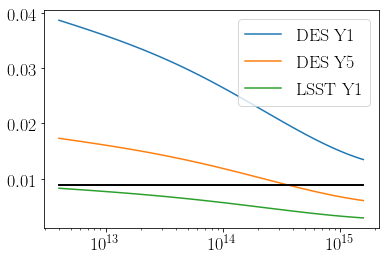

In [12]:
z = 0.2
base_args = get_base(z)
for i, name in enumerate(names):
    SD = source_densities[i]
    zstar = zstars[i]
    area = areas[i]
    args = get_args(z, SD, zstar, area, base_args)
    
    M = args["M"]
    nu = args["nu"]

    sigma2DS = get_sigmaDS2(M, z, args)
    acc = get_bias_accuracy(z, args, frac_over)
    acc_model = accuracy_model.accuracy_at_nu_z(nu, z)
    plt.plot(M, acc, label=name)
    plt.plot(M, acc_model, c='k')
plt.xscale('log')
plt.legend()    

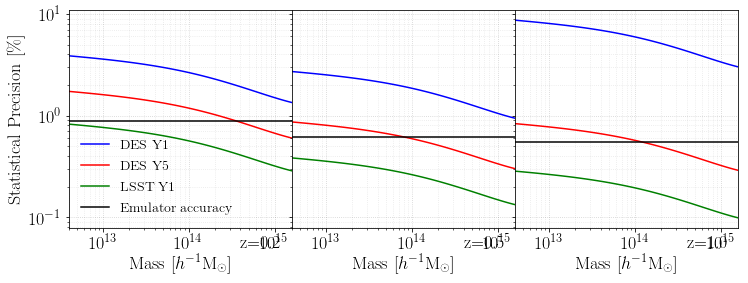

In [13]:
zs = [0.2, 0.5, 1.0]
colors = ["b", "r", "g"]
fig, ax = plt.subplots(ncols=3, nrows=1, sharex=True, sharey=True, figsize = (4*len(zs), 4))

for j,z in enumerate(zs):
    base_args = get_base(z)
    nu = base_args["nu"]
    for i, name in enumerate(names):
        SD = source_densities[i]
        zstar = zstars[i]
        area = areas[i]
        args = get_args(z, SD, zstar, area, base_args)
    
        M = args["M"]

        acc = get_bias_accuracy(z, args, frac_over)
        ax[j].plot(M, acc*scale, label=name, c=colors[i])
    nu = base_args["nu"]
    acc_model = accuracy_model.accuracy_at_nu_z(nu, z)
    ax[j].plot(M, acc_model*scale, c='k', label="Emulator accuracy")
    ax[j].set_xscale('log')
    ax[j].set_yscale('log')
    ax[j].text(4e14, 0.05, r"z=%.1f"%z, fontsize=18)
    ax[j].set_xlabel(r"${\rm Mass}\ [h^{-1}{\rm M}_\odot]$")
    #ax[j].set_xlabel("Mass")
    ax[j].set_xlim(min(M), max(M))
    #ax[j].set_ylim(0.005, 0.048)
    al = 0.2 #alpha
    ax[j].grid(which="major",color='k', alpha=al, ls=':')
    ax[j].grid(which="minor",color='k', alpha=al/2, ls=':')

ax[0].legend(loc=0, frameon=False, fontsize=14)
ax[0].set_ylabel(y_axis_label)
plt.subplots_adjust(wspace=0)
fig.savefig("bias_acc_DS.png", dpi=300, bbox_inches="tight")
fig.savefig("bias_acc_DS.pdf", dpi=300, bbox_inches="tight")

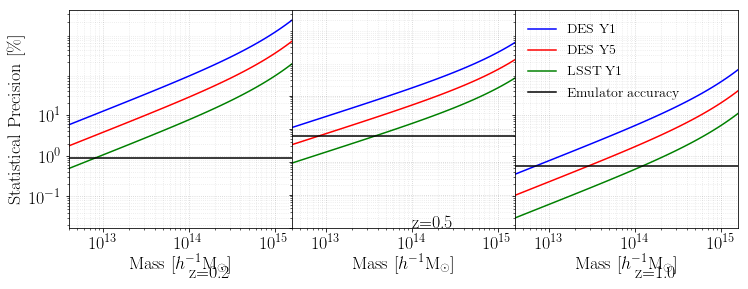

In [14]:
zs = [0.2, 0.5, 1.0]
colors = ["b", "r", "g"]
fig, ax = plt.subplots(ncols=3, nrows=1, sharex=True, sharey=True, figsize = (4*len(zs), 4))

for j,z in enumerate(zs):
    base_args = get_base(z)
    nu = base_args["nu"]
    for i, name in enumerate(names):
        SD = source_densities[i]
        zstar = zstars[i]
        area = areas[i]
        args = get_args(z, SD, zstar, area, base_args)
    
        M = args["M"]

        acc = get_bias_accuracy_xihh(z, args, frac_over)
        ax[j].plot(M, acc*scale, label=name, c=colors[i])
    nu = base_args["nu"]
    acc_model = accuracy_model.accuracy_at_nu_z(nu, z)
    ax[j].plot(M, acc_model*scale, c='k', label="Emulator accuracy")
    ax[j].set_xscale('log')
    ax[j].set_yscale('log')
    ax[j].text(1e14, 0.001, r"z=%.1f"%z, fontsize=18)
    ax[j].set_xlabel(r"${\rm Mass}\ [h^{-1}{\rm M}_\odot]$")
    #ax[j].set_xlabel("Mass")
    ax[j].set_xlim(min(M), max(M))
    #ax[j].set_ylim(0.005, 0.048)
    al = 0.2 #alpha
    ax[j].grid(which="major",color='k', alpha=al, ls=':')
    ax[j].grid(which="minor",color='k', alpha=al/2, ls=':')

ax[1].set_yticks([1e-3,1e-2,1e-1,1e0,1e1])
#ax[1].set_yticklabels([1e-3,1e-2,1e-1,1e0,1e1])

ax[2].legend(loc=0, frameon=False, fontsize=14)
ax[0].set_ylabel(y_axis_label)
plt.subplots_adjust(wspace=0)
fig.savefig("bias_acc_xihh.png", dpi=300, bbox_inches="tight")
fig.savefig("bias_acc_xihh.pdf", dpi=300, bbox_inches="tight")

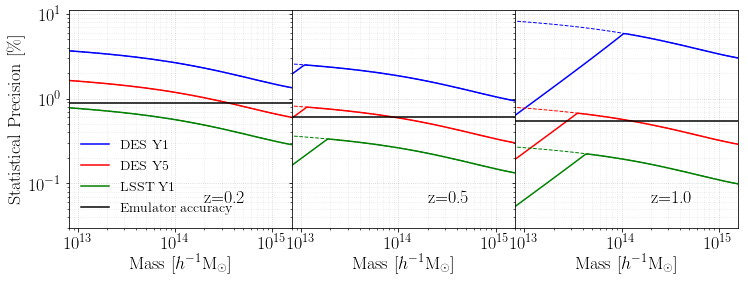

In [16]:
zs = [0.2, 0.5, 1.0]
colors = ["b", "r", "g"]
fig, ax = plt.subplots(ncols=3, nrows=1, sharex=True, sharey=True, figsize = (4*len(zs), 4))

for j,z in enumerate(zs):
    base_args = get_base(z)
    nu = base_args["nu"]
    for i, name in enumerate(names):
        SD = source_densities[i]
        zstar = zstars[i]
        area = areas[i]
        args = get_args(z, SD, zstar, area, base_args)
    
        M = args["M"]

        acc1 = get_bias_accuracy(z, args)
        acc2 = get_bias_accuracy_xihh(z, args)
        acc = np.array([acc1,acc2])
        acc = np.min(acc, 0)
        ax[j].plot(M, acc*scale, label=name, c=colors[i])
        ax[j].plot(M, acc1*scale, ls="--", c=colors[i], lw=1)
        #ax[j].plot(M, acc2, ls=":", c=colors[i], lw=1)
    nu = base_args["nu"]
    acc_model = accuracy_model.accuracy_at_nu_z(nu, z)
    ax[j].plot(M, acc_model*scale, c='k', label="Emulator accuracy")
    ax[j].set_xscale('log')
    ax[j].set_yscale('log')
    #Text in upper left
    #ax[j].text(6e12, 0.05, r"z=%.1f"%z, fontsize=15)
    #Text in bottom right
    ax[j].text(2e14, 0.0006*scale, r"z=%.1f"%z, fontsize=18)
    ax[j].set_xlabel(r"${\rm Mass}\ [h^{-1}{\rm M}_\odot]$")
    #ax[j].set_xlabel("Mass")
    ax[j].set_xlim(min(M), max(M))
    ax[j].set_xlim(8e12, max(M))
    ax[j].set_ylim(0.0003*scale, 0.11*scale)
    al = 0.2 #alpha
    ax[j].grid(which="major", color='k', alpha=al, ls=':')
    ax[j].grid(which="minor", color='k', alpha=al/2, ls=':')
    
#ax[2].legend(loc="center right",frameon=False, fontsize=11)
ax[0].legend(loc=0,frameon=False, fontsize=14)
ax[0].set_ylabel(y_axis_label)
plt.subplots_adjust(wspace=0)
fig.savefig("bias_accuracy_requirement.png", dpi=300, bbox_inches="tight")
fig.savefig("bias_accuracy_requirement.pdf", dpi=300, bbox_inches="tight")